In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data
from time import time
from torchvision import datasets, transforms
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

if torch.cuda.is_available() :
    device = "cuda:0"
    print("detected cuda device")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else :
    device = "cpu"
    torch.set_default_tensor_type(torch.FloatTensor)
    

BATCH_SIZE = 32

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./data/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('./data/test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True)


In [6]:
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=2)
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(2,2)
        self.linear2 = nn.Linear(6 * 6 * 16, 10)

    def forward(self,X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        X = X.view(-1, 6 * 6 * 16)
        X = self.linear2(X)
        return X
    
    def forward_features(self, X):
        X = self.pool1(F.relu(self.conv1(X)))
        X = self.pool2(F.relu(self.conv2(X)))
        return X

model = Net(device=device)
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear2): Linear(in_features=576, out_features=10, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
print(images.shape)
logps = model(images.to(device)) #log probabilities
loss = criterion(logps, labels.to(device)) #calculate t

torch.Size([32, 1, 28, 28])


In [8]:
def accuracy(testloader, epoch):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs= model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("Accuracy", 100 * correct / total)
        return 100 * correct / total

# accuracy(valloader, 0)

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 2
for e in range(epochs):
    running_loss = 0
    running_val_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        running_val_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("Epoch {} - Validation loss: {}".format(e, running_val_loss/len(valloader)))
        print("on train set:")
        accuracy(trainloader, e)
        print("on test set:")
        accuracy(valloader, e)
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.3261755413154761
Epoch 0 - Validation loss: 0.1076608558718008
on train set:
Accuracy 96.085
on test set:
Accuracy 96.59
Epoch 1 - Training loss: 0.1050997703710571
Epoch 1 - Validation loss: 0.07992143954668111
on train set:
Accuracy 97.37833333333333
on test set:
Accuracy 97.44

Training Time (in minutes) = 0.741323959827423


In [6]:
PATH = './mnist_net'
torch.save(model.state_dict(), PATH)

Poniżej dane wskazujące na przetrenowania


Epoch 0 - Training loss: 0.3483577066699664
Epoch 0 - Training loss: 0.10861856871233962
on train set:
Accuracy 96.57
on test set:
Accuracy 96.76
Epoch 1 - Training loss: 0.10320847239891688
Epoch 1 - Training loss: 0.07951102484338962
on train set:
Accuracy 97.55
on test set:
Accuracy 97.52
Epoch 2 - Training loss: 0.07951653525431951
Epoch 2 - Training loss: 0.06962830385270591
on train set:
Accuracy 97.98
on test set:
Accuracy 97.79
Epoch 3 - Training loss: 0.06738914438883463
Epoch 3 - Training loss: 0.05580564471669852
on train set:
Accuracy 98.35833333333333
on test set:
Accuracy 98.2

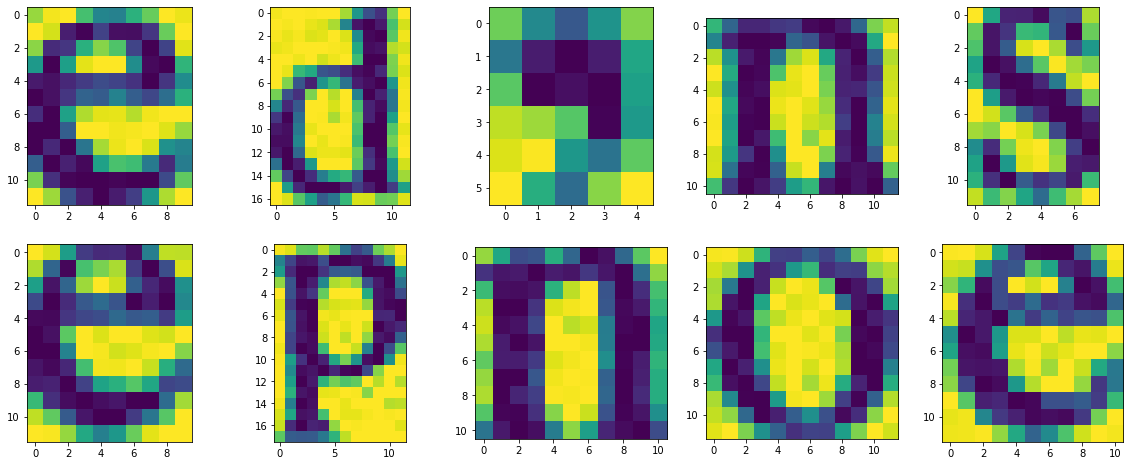

In [20]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision import models

train_set = datasets.ImageFolder(root = './data/zajads_sample',
                transform = transforms.Compose([
                    transforms.Grayscale(),
                    transforms.ToTensor()
                ]))

def imshow(data):
    for img,_ in data:
        plt.imshow(img[0].numpy())
        plt.show()


def imshow_many(imgs):
    n = len(imgs)
    if n < 20:
        cols = 5
        rows = int((n + 4) / 5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else:
        cols = 10
        rows = int((n + 9) / 10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        sub.imshow(imgs[i][0][0].numpy(), interpolation='nearest')
    plt.show()
    
imshow_many([train_set[i] for i in range(10)])
plt.show()

In [37]:
x = train_set[0][0]
x.shape

torch.Size([1, 12, 10])

In [38]:
model.forward_features(x.reshape((1,1,12,10))).shape

torch.Size([1, 16, 2, 1])

In [39]:
y = model.forward_features(x.reshape((1,1,12,10))).mean(dim=3).mean(dim=2)[0]

In [40]:
y

tensor([1.7784, 0.0000, 3.5374, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6234,
        0.9218, 1.5524, 0.0464, 0.4662, 1.6038, 0.2207, 1.5665],
       grad_fn=<SelectBackward>)

In [33]:
x1 = train_set[0][0]
x2 = train_set[1][0]

In [41]:
y1 = model.forward_features(x1.reshape((1,1,12,10))).mean(dim=3).mean(dim=2)[0]
y2 = model.forward_features(x2.reshape((1,1,17,12))).mean(dim=3).mean(dim=2)[0]

In [45]:
print(y1)
print(y2)

tensor([1.7784, 0.0000, 3.5374, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.6234,
        0.9218, 1.5524, 0.0464, 0.4662, 1.6038, 0.2207, 1.5665],
       grad_fn=<SelectBackward>)
tensor([0.8469, 0.0000, 3.1814, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.3579,
        1.6150, 0.9583, 0.0000, 0.2913, 2.0948, 0.0967, 1.5570],
       grad_fn=<SelectBackward>)


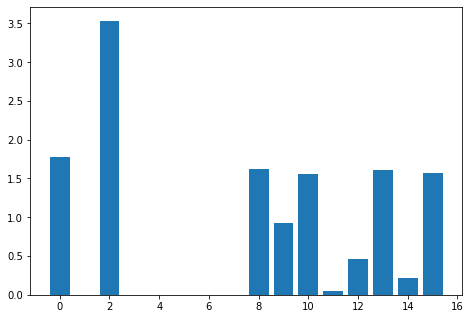

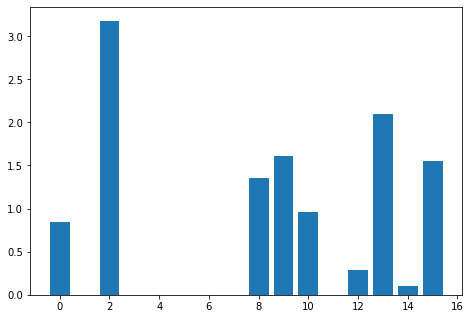

In [52]:

def plotValues(y):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(np.arange(y.shape[0]),y.detach().numpy())
    plt.show()

plotValues(y1)
plotValues(y2)

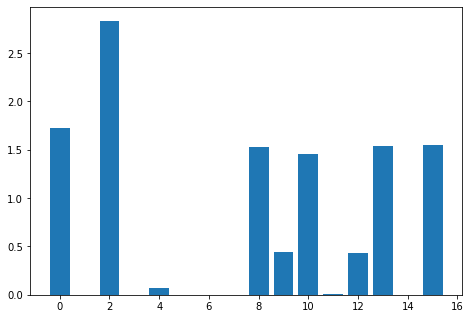

In [53]:
x3 = train_set[4][0]
y3 = model.forward_features(x3.reshape((1,1,x3.shape[-2],x3.shape[-1]))).mean(dim=3).mean(dim=2)[0]
plotValues(y3)